# Module

In [1]:
module RecommenderSystems

using Distributions: Normal, mean, MvNormal
using LinearAlgebra: dot
using Random: shuffle, GLOBAL_RNG
using SharedArrays: SharedArray
using Distributed#: @distributed, RemoteChannel
import Base.show

export Rating, MatrixFactorization, Item, User, SVDModel, itembiases, userbiases, fit!, predict, score, learningcurves
export SplitMethod, TrainTestSplit, LeaveOneOut, splitcv


"""
    Rating

User's rating of an item.
"""
mutable struct Rating
    item::Int64
    user::Int64
    value::Float64
end

function Base.show(io::IO, rating::Rating)
    fields = fieldnames(Rating)
    kwstr = join(["$(f)=$(getfield(rating, f))" for f in fields], ", ")
    print(io, "Rating($(kwstr))")
end


"""
    Item

An Item's weights and bias.
"""
mutable struct Item
    weights::Vector{Float64}
    bias::Float64
end


"""
    User

A User's weights and bias.
"""
mutable struct User
    weights::Vector{Float64}
    bias::Float64
end


"""
    MatrixFactorization

Abstract supertype for matrix factorization based recommender systems models.
"""
abstract type MatrixFactorization end


"""
    SVDModel <: MatrixFactorization

SVD based recommender systems model.
"""
mutable struct SVDModel <: MatrixFactorization
    # Factorization
    items::Dict{Int64, Item}
    users::Dict{Int64, User}
    k::Int64
    
    # Initialization
    mean::Float64
    std::Float64
    
    # Baseline
    bias::Float64
    
    # SGD
    nepochs::Int64
    lr::Float64
    reg::Float64
end


"""
    SVDModel(; <keyword arguments>)

# Arguments
- `k::Int64=10`: the number of factors.
- `mean::Float64=0.0`: mean of the normal distribution used to initialize the factorization matrices.
- `std::Float64=1e-4`: standard deviation of the normal distribution used to initialize the factorization matrices.
- `nepochs:::Int64=20`: number of epochs processed during stochastic gradient descent optimization.
- `lr::Float64=0.005`: learning rate used during gradient descent optimization.
- `reg::Float64=0.02`: regularization parameter used during gradient descent optimization.
"""
function SVDModel(;
        k::Int64=10,
        mean::Float64=0.0,
        std::Float64=1e-4,
        nepochs::Int64=10,
        lr::Float64=0.001,
        reg::Float64=0.0)
    
    items = Dict{Int64, Item}()
    users = Dict{Int64, User}()
    bias = 0.0
    
    SVDModel(items,users,k,mean,std,bias,nepochs,lr,reg)
end

function Base.show(io::IO, model::SVDModel)
    fields = [:k, :nepochs, :lr, :reg]
    kwstr = join(["$(f)=$(getfield(model, f))" for f in fields], ", ")
    print(io, "SVD($(kwstr),...)")
end

function User(model::SVDModel)
    User(rand(MvNormal(model.k, model.std)), 0.0)
    #User(rand(Normal(model.mean, model.std), model.k), 0.0)
end

function Item(model::SVDModel)
    Item(rand(MvNormal(model.k, model.std)), 0.0)
    #Item(rand(Normal(model.mean, model.std), model.k), 0.0)
end

function userbiases(model::SVDModel)
    (get(model.users,i,User(model)).bias for i in 1:maximum(keys(model.users)))
end

function itembiases(model::SVDModel)
    (get(model.items,i,Item(model)).bias for i in 1:maximum(keys(model.items)))
end

"""
    fit!(model::SVDModel, ratings::Vector{Ratings}; cb::Union{Function, Nothing}=nothing)

Fit the model by optimizing a regularized SSE(Summed Squared Error) through stochastic gradient descent.

If passed as the keyword argument `cb`, a callback function will be called at the end of each epoch
with arguments `nepoch::Int64` and `cost::Float64`.
"""
function fit!(model::SVDModel, ratings::Vector{Rating}; cb::Union{Function, Nothing}=nothing)
    model.bias = mean(r.value for r in ratings)
    for r in ratings
        if !(r.item in keys(model.items))
            model.items[r.item] = Item(model)
        end
        if !(r.user in keys(model.users))
            model.users[r.user] = User(model)
        end
    end
    
    for epoch in 1:model.nepochs
        currentcost = 0
        for r in shuffle(ratings)
            item = model.items[r.item]
            user = model.users[r.user]

            e = model.bias + item.bias + user.bias + dot(item.weights, user.weights) - r.value

            currentcost += abs2(e)
            
            item.weights .-= model.lr .* 2 .* (e .* user.weights .+ model.reg .* item.weights)
            user.weights .-= model.lr .* 2 .* (e .* item.weights .+ model.reg .* user.weights)
            item.bias -= model.lr * 2 * (e + model.reg * item.bias)
            user.bias -= model.lr * 2 * (e + model.reg * user.bias)
        end
        
        if cb !== nothing
            cb(epoch, currentcost)
        end
    end
end


"""
    predict(model::SVDModel, item::Int64, user::Int64)

Predict the rating of an item by a user.
"""
function predict(model::SVDModel, item::Int64, user::Int64)
    item = get(model.items, item, Item(zeros(Float64, model.k), 0.0))
    user = get(model.users, user, User(zeros(Float64, model.k), 0.0))

    model.bias + item.bias + user.bias + dot(item.weights, user.weights)
end


"""
    score(model::SVDModel, ratings::Vector{Rating})

Compute the score of the fitted model using SSE(Summed Squared Error).
"""
function score(model::SVDModel, ratings::Vector{Rating})
    sum(abs2, (predict(model, r.item, r.user) - r.value) for r in ratings)
end


"""
    learningcurves(model::SVDModel, train::Vector{Rating}, test::Vector{Rating}, step::Int64=1; cb::Union{Function, Nothing}=nothing)

Successively compute the train and test scores necessary to plot the learning curves of the model.
"""
function learningcurves(model::SVDModel, train::Vector{Rating}, test::Vector{Rating}, step::Int64=1; cb::Union{Function, Nothing}=nothing)
    sizes = collect(1:step:length(train))
    trainscores = SharedArray{Float64}(length(sizes))
    testscores = SharedArray{Float64}(length(sizes))
    
    done = RemoteChannel(() -> Channel{Bool}(32))

    @distributed for (i,s) in collect(enumerate(sizes))
        m = deepcopy(model)
        fit!(m, train[1:s])
        trainscores[i] = score(m, train[1:s])
        testscores[i] = score(m, test)
        put!(done, true)
    end
    
    for i in 1:length(sizes)
        take!(done)
        if cb !== nothing
            cb(i, length(sizes))
        end
    end
    
    return (sizes, trainscores, testscores)
end

# BEGIN: ModelSelection module
"""
    SplitMethod

Abstract supertype for dataset splitting methods.
"""
abstract type SplitMethod end


"""
    TrainTestSplit <: SplitMethod

Split a vector of ratings into a training and a test set, according to a percentage ratio.
"""
mutable struct TrainTestSplit <: SplitMethod
    ratio::Float64
    shuffle::Bool
    rng
end

"""
    TrainTestSplit(ratio::Float64; shuffle::Bool=false, rng=GLOBAL_RNG)

Split a vector of ratings into a training and a test set, according to a percentage ratio.

# Arguments
- `ratio::Float64`: the percentage of ratings to put in training set.
- `shuffle::Bool=false`: whether to randomly shuffle the ratings before splitting or not.
- `rng=GLOBAL_RNG`: random number generator to shuffle with.
"""
function TrainTestSplit(ratio::Float64; shuffle::Bool=false, rng=GLOBAL_RNG)
    TrainTestSplit(ratio, shuffle, rng)
end

"""
    split(method::TrainTestSplit, ratings::Vector{Rating})::NTuple{2, Vector{Rating}}

Split a vector of ratings into a training and a test set, according to a percentage ratio.
"""
function splitcv(method::TrainTestSplit, ratings::Vector{Rating})::NTuple{2, Vector{Rating}}
    if method.shuffle
        ratings = shuffle(method.rng, ratings)
    end
    idx = round(Int, length(ratings) * method.ratio)
    return (ratings[1:idx], ratings[idx+1:end])
end

"""
    LeaveOneOut <: SplitMethod

Split a vector of ratings into a training and a test set, each user has exactly one rating in the test set.
"""
mutable struct LeaveOneOut <: SplitMethod
    minratings::Int64
    shuffle::Bool
    rng
end

"""
    LeaveOneOut(;minratings::Int64=0, shuffle::Bool=false, rng=GLOBAL_RNG)

Split a vector of ratings into a training and a test set, each user has exactly one rating in the test set.

minratings sets the minimum number of ratings for each user in the trainset, others will be discarded.

# Arguments
- `rng=GLOBAL_RNG`: random number generator to shuffle with.
"""
function LeaveOneOut(;minratings::Int64=0, shuffle::Bool=false, rng=GLOBAL_RNG)
    LeaveOneOut(minratings, shuffle, rng)
end

"""
    splitcv(method::LeaveOneOut, ratings::Vector{Rating})::NTuple{2, Vector{Rating}}

Split a vector of ratings into a training and a test set, each user has exactly one rating in the test set.
"""
function splitcv(method::LeaveOneOut, ratings::Vector{Rating})::NTuple{2, Vector{Rating}}
    if method.shuffle
        ratings = shuffle(method.rng, ratings)
    end
    trainset = Rating[]
    testset = Rating[]
    users = Dict{Int64, NamedTuple{(:count, :done), Tuple{Int64, Bool}}}()
    
    for r in ratings
        user = get!(users, r.user, (count=0, done=false))
        users[r.user] = (count=user.count+1, done=user.done)
    end
    
    for r in ratings
        user = users[r.user]
        if user.count >= method.minratings
            if !user.done
                push!(testset, r)
                users[r.user] = (count=user.count, done=true)
            else
                push!(trainset, r)
            end
        end
    end
            
    return (trainset, testset)
end
# END: ModelSelection module

end

Main.RecommenderSystems

### Write module to file

In [2]:
write("RecommenderSystems.jl", In[1])

9410

# Main

In [3]:
using .RecommenderSystems, PyCall, Distributed, Plots, IJulia, Random, Statistics, Distributions, SparseArrays

loadmat = pyimport("scipy.io")["loadmat"]
data = loadmat("ex8_movies.mat")
Y = convert(Array{Float64}, data["Y"]);

### Initialize workers

In [ ]:
addprocs(4)
@everywhere push!(LOAD_PATH, ".")
@everywhere workers() using RecommenderSystems

### Destroy workers

In [ ]:
rmprocs(workers())

### fit! test

Processed epoch #10: 80416.6677158398
  0.641772 seconds (310.81 k allocations: 22.798 MiB, 3.18% gc time)


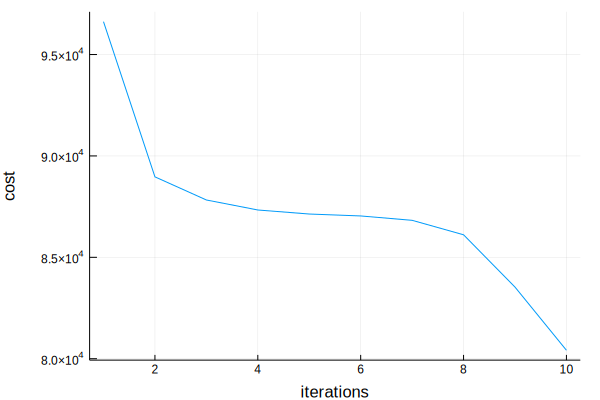

In [5]:
model1 = SVDModel(k=10, nepochs=10, lr=0.013, reg=0.0)
ratings = [Rating(ci.I[1], ci.I[2], Y[ci]) for ci in findall(x->x>0, Y)]
shuffle!(ratings)
costs = Float64[]
@time fit!(model1, ratings, cb=(epoch, cost) -> begin
    IJulia.clear_output(true)
    println("Processed epoch #$(epoch): $(cost)")
    push!(costs, cost)
end)

plot(costs, xlabel="iterations", ylabel="cost", legend=false)

In [ ]:
score(model1, ratings)

In [ ]:
map(ci -> predict(model1, ci.I[1], ci.I[2]), CartesianIndices(Y))

### learningcurves test

In [ ]:
ratings = [Rating(ci.I[1], ci.I[2], Y[ci]) for ci in findall(x->x>0, Y)]
trainset, testset = splitcv(TrainTestSplit(0.9, shuffle=true), ratings);

In [ ]:
ratings = [Rating(ci.I[1], ci.I[2], Y[ci]) for ci in findall(x->x>0, Y)]
trainset, testset = splitcv(LeaveOneOut(shuffle=true), ratings);

In [ ]:
@time let model = SVDModel(k=100, nepochs=100, lr=0.01, reg=0.008)
    global sizes, trainscores, testscores = learningcurves(model, trainset, testset, 10000, cb=(index, total) -> begin
            IJulia.clear_output(true)
            println("Trained $(index)/$(total)")
            end)
end

plot(sizes, trainscores, xlabel="number of examples", ylabel="score", label="train score")
plot!(sizes, testscores, label="test score")

### ALS test

In [ ]:
@everywhere using LinearAlgebra, SharedArrays, SparseArrays
function als!(model::SVDModel, ratings::Vector{Rating}; cb::Union{Function, Nothing}=nothing)
    R = dropzeros(sparse([r.item for r in ratings], [r.user for r in ratings], [r.value for r in ratings]))
    nitems, nusers = R.m, R.n
    
    rateditems, ratingusers, rates = findnz(R)
    for i in Set(rateditems)
        model.items[i] = Item(model)
    end
    for u in Set(ratingusers)
        model.users[u] = User(model)
    end
    
    model.bias = mean(nonzeros(R))
    bi = SharedArray{Float64}(nitems)
    bu = SharedArray{Float64}(nusers)
    
    P = SharedArray{Float64}(nitems, model.k)
    P .= rand(Normal(model.mean, model.std), nitems, model.k)
    Q = SharedArray{Float64}(nusers, model.k)
    Q .= rand(Normal(model.mean, model.std), nusers, model.k)
    
    function updatefactors()
        for i in Set(rateditems)
            model.items[i] = Item(P[i,:], bi[i])
        end
        for u in Set(ratingusers)
            model.users[u]  = User(Q[u,:], bu[u])
        end
    end
    
    R_mu = R .- model.bias
    rtol = sqrt(eps(real(float(one(Float64)))))
    
    for epoch in 1:model.nepochs
        P_biased = [ones(nitems) P]
        R_mu_bi = R_mu .- bi
        @sync @distributed for u in 1:nusers
            rated_items_indices = R[:, u].nzind
            P_biased_truncated = P_biased[rated_items_indices, :]
            A = P_biased_truncated' * P_biased_truncated + model.reg * I
            b = P_biased_truncated' * R_mu_bi[rated_items_indices, u]
            x = pinv(A, rtol) * b
            bu[u], Q[u,:] = x[1], x[2:end]
        end
        
        Q_biased = [ones(nusers) Q]
        R_mu_bu = R_mu .- bu'
        @sync @distributed for i in 1:nitems
            rating_users_indices = R[i, :].nzind
            Q_biased_truncated = Q_biased[rating_users_indices, :]
            A = Q_biased_truncated' * Q_biased_truncated + model.reg * I
            b = Q_biased_truncated' * R_mu_bu[i, rating_users_indices]
            x = pinv(A, rtol) * b
            bi[i], P[i,:] = x[1], x[2:end]
        end
        
        if cb !== nothing
            updatefactors()
            currentcost = score(model, ratings)
            cb(epoch, currentcost)
        end
    end
    
    updatefactors()
end

In [ ]:
costs = Float64[]
model2 = SVDModel(k=100, nepochs=20, lr=0.01, reg=0.0)
ratings = [Rating(ci.I[1], ci.I[2], Y[ci]) for ci in findall(x->x>0, Y)]
@time als!(model2, ratings, cb=(epoch, cost) -> begin
        IJulia.clear_output(true)
        println("Processed epoch #$(epoch): $(cost)")
        push!(costs, cost)
        end)

plot(costs, xlabel="iterations", ylabel="cost", legend=false)

In [ ]:
@everywhere using LinearAlgebra, SharedArrays, SparseArrays
function veals!(model::SVDModel, ratings::Vector{Rating}; cb::Union{Function, Nothing}=nothing)
    R = dropzeros(sparse([r.user for r in ratings], [r.item for r in ratings], [r.value for r in ratings]))
    nusers, nitems = R.m, R.n
    
    ratingusers, rateditems, rates = findnz(R)
    for i in Set(rateditems)
        model.items[i] = Item(model)
    end
    for u in Set(ratingusers)
        model.users[u] = User(model)
    end
    
    P = SharedArray{Float64}(nusers, model.k)
    P .= rand(Normal(model.mean, model.std), nusers, model.k)
    Q = SharedArray{Float64}(nitems, model.k)
    Q .= rand(Normal(model.mean, model.std), nitems, model.k)
    
    Predictions = SharedArray{Float64}(nusers, nitems)
    Predictions_minus = SharedArray{Float64}(nusers, nitems)
    
    for r in ratings
        Predictions[r.user, r.item] = P[r.user,:]'*Q[r.item,:]
    end
    
    W = sparse(ratingusers, rateditems, ones(length(ratingusers)))
    
    function updatefactors()
        for i in Set(rateditems)
            model.items[i] = Item(Q[i,:], 0.0)
        end
        for u in Set(ratingusers)
            model.users[u]  = User(P[u,:], 0.0)
        end
    end
    
    for epoch in 1:model.nepochs
        @sync @distributed for u in 1:nusers
            for f in 1:model.k
                Predictions_minus[u, :] = Predictions[u, :] .- P[u, f] .* Q[:, f]
                P[u, f] = sum(i->(Predictions[u,i] - Predictions_minus[u,i]) * W[u,i] * Q[i,f], 1:nitems) / sum(i->W[u,i] * Q[i,f]^2 + model.reg, 1:nitems)
                Predictions[u, :] = Predictions_minus[u, :] .+ P[u, f] .* Q[:, f]
            end
        end
        
        @sync @distributed for i in 1:nitems
            for f in 1:model.k
                Predictions_minus[:, i] = Predictions[:, i] .- P[:, f] .* Q[i, f]
                Q[i, f] = sum(u->(Predictions[u,i] - Predictions_minus[u,i]) * W[u,i] * P[u,f], 1:nusers) / sum(u->W[u,i] * P[u,f]^2 + model.reg, 1:nusers)
                Predictions[:, i] = Predictions_minus[:, i] .+ P[:, f] .* Q[i, f]
            end
        end
        
        if cb !== nothing
            updatefactors()
            currentcost = score(model, ratings)
            cb(epoch, currentcost)
        end
    end
    
    updatefactors()
end

In [ ]:
map(ci -> predict(model2, ci.I[1], ci.I[2]), CartesianIndices(Y))

### Reminder

use `collect(enumerate` with `@distributed`!!!

### TODO

- Find out with score is more important in learning curves than in gradient descent graph !!!
- Implement ALS without biases, à la NETFLIX.
- Implement K-folds
- Validation curves function
- Random CV Search Function